In [155]:
import os
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
import time
# from tqdm.notebook import tqdm

module_path = os.path.abspath(os.path.join('../../src/'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import Resnet_multiscale as net

#===========================================================================================================

# adjustables

k = 5                       # model index: should be in {0, 2, ..., 10}
dt = 0.01                     # time unit: 0.0005 for Lorenz and 0.01 for others
system = 'VanDerPol'         # system name: 'Hyperbolic', 'Cubic', 'VanDerPol', 'Hopf' or 'Lorenz'
noise = 0.01                   # noise percentage: 0.00, 0.01 or 0.02

lr = 1e-3                     # learning rate
max_epoch = 50000            # the maximum training epoch 
batch_size = 320              # training batch size
arch = [2, 512, 512, 512, 2]  # architecture of the neural network

# paths
data_dir = os.path.join('../../data/', system,)
model_dir = '../../models/VanDerPol_multiscale'

# global const
n_forward = 5
step_size = 2**k


        
# load data
train_data = np.load(os.path.join(data_dir, 'train_noise{}.npy'.format(noise)))
val_data = np.load(os.path.join(data_dir, 'val_noise{}.npy'.format(noise)))
test_data = np.load(os.path.join(data_dir, 'test_noise{}.npy'.format(noise)))
n_train = train_data.shape[0]
n_val = val_data.shape[0]
n_test = test_data.shape[0]

print("train_data shape = ", train_data.shape)
print("val_data shape = ", val_data.shape)
print("test_data.shape = ", test_data.shape)

step_size = 8
n_forward = 4

dataset = net.DataSet(train_data, val_data, test_data, dt, step_size, n_forward)

print(dataset.train_ys.shape)

train_data shape =  (3200, 5121, 2)
val_data shape =  (320, 5121, 2)
test_data.shape =  (320, 5121, 2)
torch.Size([3200, 4, 2])


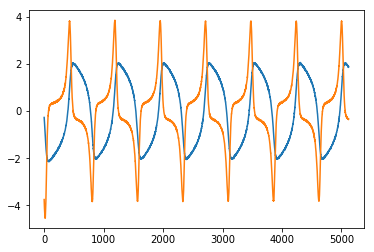

In [156]:
plt.plot(train_data[0,:,0])
plt.plot(train_data[0,:,1])

In [157]:
#make and train
model_name = 'model_D{}_noise{}.pt'.format(step_size, noise)

# # create/load model object
try:
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = torch.load(os.path.join(model_dir, model_name), map_location=device)
    model.device = device
    print("model loaded ", model_name)
except:


    # create/load model object
    print('create model {} ...'.format(model_name))
    model = net.ResNet(arch=arch, dt=dt, step_size=step_size)#, prev_models=prev_models)

    # training
model.train_net(dataset, max_epoch=max_epoch, batch_size=batch_size, lr=lr,
                model_path=os.path.join(model_dir, model_name))

create model model_D8_noise0.01.pt ...
time for first 10 =  0.2948191165924072
epoch 1000, training loss 0.01362559199333191, validation loss 0.006745560560375452
(--> new model saved @ epoch 1000)
epoch 2000, training loss 0.013090026564896107, validation loss 0.006566197611391544
(--> new model saved @ epoch 2000)
epoch 3000, training loss 0.009874371811747551, validation loss 0.005252919625490904
(--> new model saved @ epoch 3000)
epoch 4000, training loss 0.006643302738666534, validation loss 0.0053190491162240505
epoch 5000, training loss 0.008692617528140545, validation loss 0.005474597681313753
epoch 6000, training loss 0.009490233846008778, validation loss 0.005336578469723463
epoch 7000, training loss 0.006903497967869043, validation loss 0.00535937724635005


KeyboardInterrupt: 

In [158]:
# load models
models = list()
percent_data = 0.2
# for noise in noise_levels:
try:
    model_name = 'model_D{}_noise{}.pt'.format(step_size, noise)
    print(model_name)
    models.append(torch.load(os.path.join(model_dir, model_name), map_location='cpu'))
except:
    print("not found")
#     break

# fix model consistencies trained on gpus (optional)
for model in models:
    model.device = 'cpu'
    model._modules['small']._modules['activation'] = torch.nn.ReLU()
    model._modules['large']._modules['activation'] = torch.nn.ReLU()
  

model_D8_noise0.01.pt


In [159]:
test_data = np.load(os.path.join(data_dir, 'test_noise{}.npy'.format(noise)))

torch.Size([320, 2])
torch.Size([320, 4, 2])
torch.Size([320, 2])
tensor([-1.8030, -0.3664], grad_fn=<SelectBackward0>)
tensor([[-1.6714, -1.1985],
        [-1.7522, -0.7423],
        [-1.7829, -0.4427],
        [-1.8285, -0.1809]], device='cuda:0')


(0, 50)

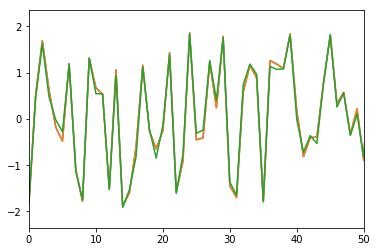

In [160]:
print(dataset.val_x.shape)
print(dataset.val_ys.shape)

y_preds = models[0].forward(models[0].forward(dataset.val_x.to('cpu'), 'small'), 'large')
y_preds1 = models[0].forward(models[0].forward(dataset.val_x.to('cpu'), 'large'), 'small')

print(y_preds.shape)

print(y_preds[0])
print(dataset.val_ys[0])

plt.plot(y_preds[:,0].detach().numpy())
plt.plot(y_preds1[:,0].detach().numpy())
plt.plot(dataset.val_ys[:,-1,0].cpu().detach().numpy())
plt.xlim([0,50])

torch.Size([320, 2])
torch.Size([320, 2])


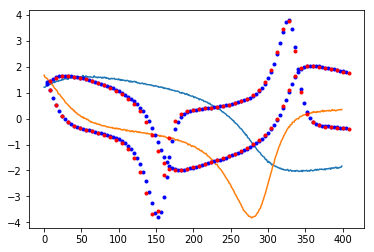

In [161]:
i = 0
plt.plot(test_data[i,:400])

step_size = 4
t = 0

t+= step_size
y_preds = models[0].forward(torch.tensor(test_data[:, 0]).float(), 'small')
print(y_preds.shape)
plt.plot([t,t], y_preds[i].detach().numpy() , 'b.' )

for j in range(100):
    t+= step_size
    y_preds = models[0].forward(y_preds, 'small')
    plt.plot([t,t], y_preds[i].detach().numpy() , 'b.' )
    
    
step_size = 8
t = 0

t+= step_size
y_preds = models[0].forward(torch.tensor(test_data[:, 0]).float(), 'large')
print(y_preds.shape)
plt.plot([t,t], y_preds[i].detach().numpy() , 'r.' )

for j in range(50):
    t+= step_size
    y_preds = models[0].forward(y_preds, 'large')
    plt.plot([t,t], y_preds[i].detach().numpy() , 'r.' )
    
    

1250
torch.Size([320, 2])


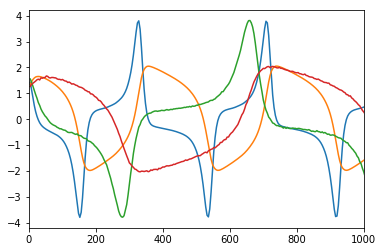

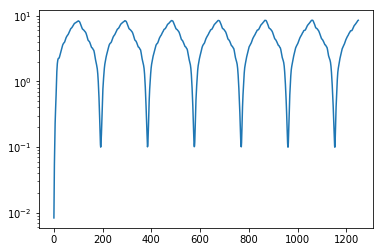

In [162]:
#want to find mse


timesteps = 5000

y_pred_list = list()
t_list = list()
step_size = 4
t = 0

points = timesteps // step_size

print(points)

t_list = np.zeros(points)
y_pred_list = np.zeros((320, points, 2))

t+= step_size
y_preds = models[0].forward(torch.tensor(test_data[:, 0]).float(), 'small')
y_pred_list[:,0] = y_preds.detach().numpy()
t_list[0] = t
print(y_preds.shape)

for j in range(points-1):
    t+= step_size
    y_preds = models[0].forward(y_preds, 'small')
    
    y_pred_list[:,j+1] = y_preds.detach().numpy()
    t_list[j+1] = t
    

plt.plot(t_list, y_pred_list[0,:, 1])
plt.plot(t_list, y_pred_list[0,:, 0])

plt.plot(t_list, test_data[0,t_list.astype(int), 1])
plt.plot(t_list, test_data[0,t_list.astype(int), 0])

# print(test_data[:,:804:4].shape)
mse4 = np.mean((y_pred_list - test_data[:,t_list.astype(int)])**2, axis = (0,2))
t_list4 = t_list
plt.xlim([0,1000])
plt.show()

plt.semilogy(mse4)

In [163]:
print

<function print>

torch.Size([320, 2])
(625,)
(320, 625, 2)


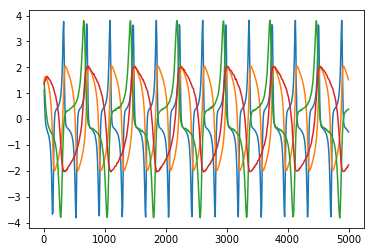

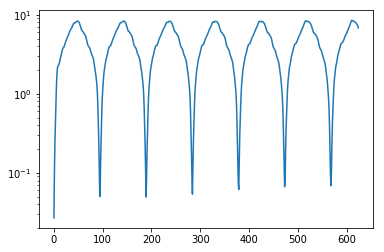

In [164]:
#want to find mse

y_pred_list = list()
t_list = list()
step_size = 8
t = 0

points = timesteps // step_size

t_list = np.zeros(points)
y_pred_list = np.zeros((320, points, 2))

t+= step_size
y_preds = models[0].forward(torch.tensor(test_data[:, 0]).float(), 'large')
y_pred_list[:,0] = y_preds.detach().numpy()
t_list[0] = t
print(y_preds.shape)

for j in range(points-1):
    t+= step_size
    y_preds = models[0].forward(y_preds, 'large')
    
    y_pred_list[:,j+1] = y_preds.detach().numpy()
    t_list[j+1] = t
    

print(t_list.shape)
print(y_pred_list.shape)

plt.plot(t_list, y_pred_list[0,:, 1])
plt.plot(t_list, y_pred_list[0,:, 0])

plt.plot(t_list, test_data[0,t_list.astype(int), 1])
plt.plot(t_list, test_data[0,t_list.astype(int), 0])
mse8 = np.mean((y_pred_list - test_data[:,t_list.astype(int)])**2, axis = (0,2))
t_list8 = t_list
plt.show()

plt.semilogy(mse8)

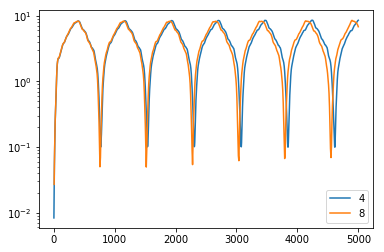

In [165]:
plt.semilogy(t_list4, mse4, label = "4")
plt.semilogy(t_list8, mse8, label = "8")
plt.legend()

# plt.xlim([0, 1000])

# plt.ylim([1e-2, 10])

In [ ]:
y_pred = models[0].forward(torch.tensor(test_data[:, 0, :]).float(), 'small')
plt.plot(y_pred[0].detach().numpy())

y_pred = models[0].forward(torch.tensor(test_data[:, 0, :]).float(), 'large')
print(y_pred.shape)

plt.plot(y_pred[0].detach().numpy())